output/circle/circle_original.jpg: Average CIE76/Delta E between original and result: 20061.71647691194
output/circle/circle_original.jpg: Average CIE76/Delta E between correct and result: 13474.099413318872
output/circle/circle_original.jpg: Percent Improvement: 32.83675687060197%


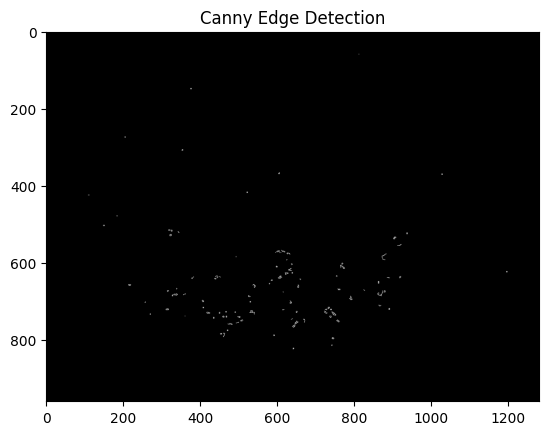

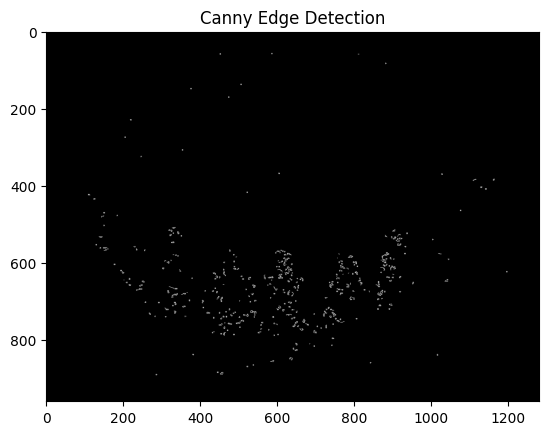

output/two/two_original.jpg: Average CIE76/Delta E between original and result: 16268.081540243153
output/two/two_original.jpg: Average CIE76/Delta E between correct and result: 15722.703902319092
output/two/two_original.jpg: Percent Improvement: 3.35243978569282%


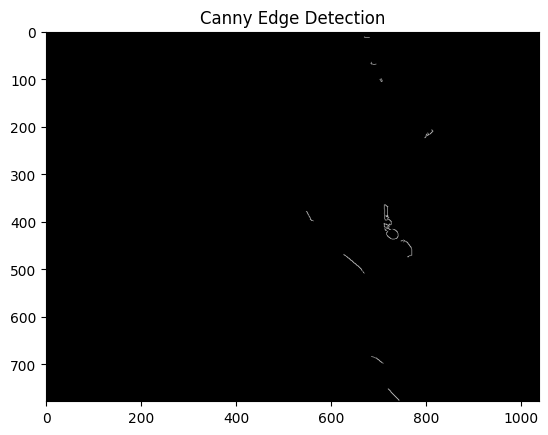

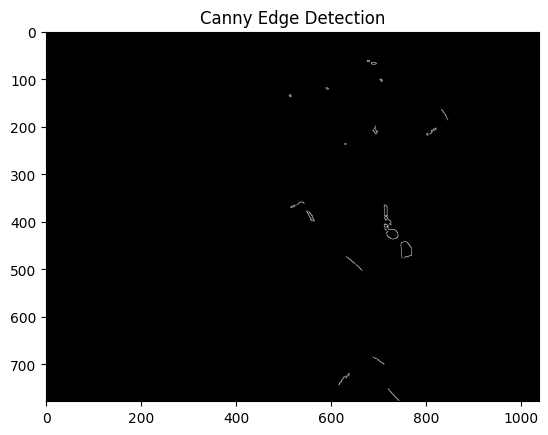

output/budda/budda_original.png: Average CIE76/Delta E between original and result: 16375.913440171818
output/budda/budda_original.png: Average CIE76/Delta E between correct and result: 13973.337360845475
output/budda/budda_original.png: Percent Improvement: 14.67140192273229%


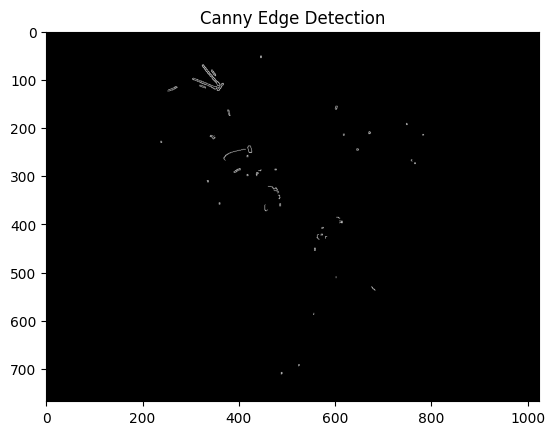

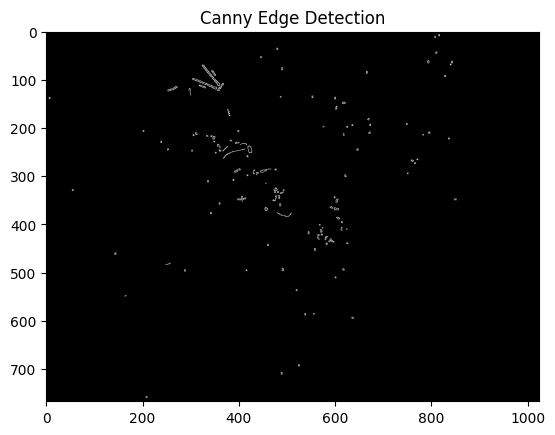

Done


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re

def read_image(img_path):
    return cv2.imread(img_path)

def write_image(img_path, img):
    cv2.imwrite(img_path, img)

def normalize(pixel):
    return np.float32(pixel) / np.max([np.max(pixel), 255]) if np.max(pixel) > 0 else np.float32(pixel)

def unnormalize(pixel):
    return np.uint8(pixel * 255) if np.max(pixel) <= 1 else np.uint8(pixel/np.max(pixel) * 255)

def convert(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
def gray_world(img):
    img_float = np.float32(img)
    avg_b = np.mean(img_float[:, :, 0])
    avg_g = np.mean(img_float[:, :, 1])
    avg_r = np.mean(img_float[:, :, 2])
    avg_all = (avg_b + avg_g + avg_r) / 3.0
    scale_b = avg_all / avg_b
    scale_g = avg_all / avg_g
    scale_r = avg_all / avg_r
    img_float[:, :, 0] *= scale_b
    img_float[:, :, 1] *= scale_g 
    img_float[:, :, 2] *= scale_r 
    img_float = np.clip(img_float, 0, 255)
    img_corrected = np.uint8(img_float)

    return img_corrected
    
def white_balanced_image(img, alpha=1, compensate_blue_channel=False):
    if len(img.shape) < 3:
        raise ValueError("Color image expected, received grayscale image")
    img = normalize(img)
    mean_red = np.mean(img[:, :, 2])
    mean_green = np.mean(img[:, :, 1])
    mean_blue = np.mean(img[:, :, 0]) if compensate_blue_channel else None
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j][2] = img[i][j][2] + alpha * (mean_green - mean_red) * (1 - img[i][j][2]) * img[i][j][1]
            if compensate_blue_channel:
                img[i][j][0] = img[i][j][0] + alpha * (mean_green - mean_blue) * (1 - img[i][j][0]) * img[i][j][1]
    return unnormalize(img)
        
def normalized_unsharp_masking(img, kernel_size=7):
    b, g, r = cv2.split(img)
    sharpened_channels = []
    for channel in [b, g, r]:
        blurred_channel = cv2.GaussianBlur(channel, (kernel_size, kernel_size), 0)
        sharpened_channel = channel - blurred_channel
        contrast_stretched_channel = cv2.normalize(sharpened_channel, None, 0, 255, cv2.NORM_MINMAX)
        sharpened_channels.append(contrast_stretched_channel)
    mask = cv2.merge(sharpened_channels)
    return np.uint8((img + mask) / 2)

def gamma_correction(img, gamma_factor=1.2):
    return np.uint8((img/255)**gamma_factor * 255)

def laplacian_contrast_weight(img):
    return cv2.convertScaleAbs(cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_64F))
    
def saliency_weight(img):
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    mean_pixel = lab_image.mean(axis=(0, 1), keepdims=True)
    blurred_image = cv2.GaussianBlur(lab_image, (3, 3), 0)
    saliency_weight = np.linalg.norm(mean_pixel - blurred_image, axis=2)
    return saliency_weight

def saturation_weight(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blue, green, red = cv2.split(img)
    return np.sqrt((1/3)*((blue - grayscale)**2 + (green - grayscale)**2 + (red - grayscale)**2))
    
def combine_weights(img1mask1, img1mask2, img1mask3, img2mask1, img2mask2, img2mask3):
    img1_weight = img1mask1 + img1mask2 + img1mask3
    img2_weight = img2mask1 + img2mask2 + img2mask3
    img1_norm = (img1_weight)/(img1_weight + img2_weight)
    img2_norm = (img2_weight)/(img1_weight + img2_weight)
    img1_norm = np.repeat(img1_norm[:, :, np.newaxis], 3, axis=-1)
    img2_norm = np.repeat(img2_norm[:, :, np.newaxis], 3, axis=-1)
    return img1_norm, img2_norm

def gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def laplacian_pyramid(image, levels):
    gaussian_pyramid_list = gaussian_pyramid(image, levels)
    laplacian_pyramid = [gaussian_pyramid_list[-1]]

    for i in range(levels - 1, 0, -1):
        size = (gaussian_pyramid_list[i - 1].shape[1], gaussian_pyramid_list[i - 1].shape[0])
        expanded = cv2.pyrUp(gaussian_pyramid_list[i], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid_list[i - 1], expanded)
        laplacian_pyramid.insert(0, laplacian)
    return laplacian_pyramid

def reconstruct_from_laplacian(pyramid):
    level = len(pyramid)

    for i in range(level - 1, 0, -1):
        m, n, c  = pyramid[i - 1].shape
        pyramid[i - 1] += pyramid[i - 1] + cv2.resize(pyramid[i], (n, m))
    output = pyramid[0]
    output=np.clip(output, 0, 255).astype(np.uint8)
    return output
    
def fusion(level, img_gamma_corrected, img_sharpened, combined_weight_gamma_corrected, combined_weight_sharpened):
    input1_laplacian_pyramid=laplacian_pyramid(img_gamma_corrected,level)
    input2_laplacian_pyramid=laplacian_pyramid(img_sharpened,level)

    combined_weight_gamma_corrected = gaussian_pyramid(combined_weight_gamma_corrected, level)
    combined_weight_sharpened = gaussian_pyramid(combined_weight_sharpened, level)

    result = []
    for i in range(level):
        fuse=np.multiply(combined_weight_gamma_corrected[i],input1_laplacian_pyramid[i]) + np.multiply(combined_weight_sharpened[i],input2_laplacian_pyramid[i])
        result.append(fuse)
    result = reconstruct_from_laplacian(result).astype(np.uint8)
    return result
    
def underwater_image_enhancement(img, title, compensate_blue_channel, gamma_factor, kernel_size, laplacian_levels):
    img_normalized = normalize(img.copy())
    img_balanced = white_balanced_image(img.copy(), compensate_blue_channel=True)
    write_image(f"{title}_white_balanced.jpg", img_balanced)
    
    img_grayworld = gray_world(img_balanced.copy())
    write_image(f"{title}_grayworld.jpg", img_grayworld)
    
    img_sharpened = normalized_unsharp_masking(img_grayworld.copy())
    write_image(f"{title}_sharpened.jpg", img_sharpened)
    
    img_gamma_corrected = gamma_correction(img_grayworld, gamma_factor=gamma_factor)
    write_image(f"{title}_gamma_corrected.jpg", img_gamma_corrected)
    
    laplacian_contrast_weight_gamma_corrected = laplacian_contrast_weight(img_gamma_corrected)
    write_image(f"{title}_laplacian_contrast_gamma_corrected.jpg", laplacian_contrast_weight_gamma_corrected)
    
    laplacian_contrast_weight_sharpened = laplacian_contrast_weight(img_sharpened)#grayscale_sharpened) 
    write_image(f"{title}_laplacian_contrast_sharpened.jpg", laplacian_contrast_weight_sharpened)

    saliency_weight_gamma_corrected = saliency_weight(img_gamma_corrected)
    write_image(f"{title}_saliency_weight_gamma_corrected.jpg", saliency_weight_gamma_corrected)  
    
    saliency_weight_sharpened = saliency_weight(img_sharpened)  
    write_image(f"{title}_saliency_weight_sharpened.jpg", saliency_weight_sharpened) 
    
    saturation_weight_gamma_corrected = saturation_weight(img_gamma_corrected)
    write_image(f"{title}_saturation_weight_gamma_corrected.jpg", unnormalize(saturation_weight_gamma_corrected)) 

    saturation_weight_sharpened = saturation_weight(img_sharpened)
    write_image(f"{title}_saturation_weight_sharpened.jpg", unnormalize(saturation_weight_sharpened)) 

    combined_weight_gamma_corrected, combined_weight_sharpened = combine_weights(laplacian_contrast_weight_gamma_corrected, saliency_weight_gamma_corrected, saturation_weight_gamma_corrected,
                                                                                 laplacian_contrast_weight_sharpened, saliency_weight_sharpened, saturation_weight_sharpened)
    write_image(f"{title}_combined_weight_gamma_corrected.jpg", unnormalize(combined_weight_gamma_corrected)) 
    write_image(f"{title}_combined_weight_sharpened.jpg", unnormalize(combined_weight_sharpened))

    result = fusion(laplacian_levels, img_gamma_corrected, img_sharpened, combined_weight_gamma_corrected, combined_weight_sharpened)

    cv2.imwrite(f'{title}_result.jpg', result)

    return result

def average_cie76(img1, img2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2Lab)
    return np.mean(np.sqrt(np.sum((img1 - img2)**2)))

def canny_edge_detection(img, title):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    plt.imshow(edges, cmap='gray')
    plt.title('Canny Edge Detection')
    plt.show()
    cv2.imwrite(f'{title}_canny.jpg', edges)
    
def main():
    keywords = ['circle', 'two', 'budda']
    image_paths = [f'output/{keyword}/{keyword}_original.jpg' for keyword in keywords]
    correct_image_paths = [f'output/{keyword}/{keyword}_correct.jpg' for keyword in keywords]
    for i, img_path in enumerate(image_paths):
        if 'budda' in img_path:
            img_path = img_path.split('.')[0]+'.png'
        img = read_image(img_path)
        compensate_blue = True
        if 'circle' in img_path:
            gamma_factor = 3
        else:
            gamma_factor = 1.5
        kernel_size = 7
        laplacian_levels = 3
        result = underwater_image_enhancement(img, re.split('[_.]', img_path)[0], compensate_blue, gamma_factor, kernel_size, laplacian_levels)#img_path.split(['_', '.'])[0])
        print(f'{img_path}: Average CIE76/Delta E between original and result: {average_cie76(img, result)}')
        print(f'{img_path}: Average CIE76/Delta E between correct and result: {average_cie76(read_image(correct_image_paths[i]), result)}')
        print(f'{img_path}: Percent Improvement: {(average_cie76(img, result) - average_cie76(read_image(correct_image_paths[i]), result))*100/average_cie76(img, result)}%')
        canny_edge_detection(img, f'{keywords[i]}_original')
        canny_edge_detection(result, f'{keywords[i]}_result')
    print("Done")

    
if __name__ == '__main__':
    main()